# Neighborhood-Based Filtering (using pytorch)

### julien.rabin (at) ensicaen.fr

In this notebook :
- Gaussian Kernel (with nn.conv)
- Bilateral Filtering
- Cross-Bilateral Filtering
- Non-Local Means
- Non-Local PCA
- Patch-based Auto-Encoder

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL

# for Jupyter notebook
%matplotlib inline 

print(torch.__version__)

In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/m

1.4.0


### 0 - Load stuff

1.0


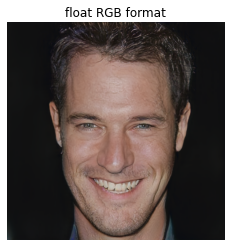

In [3]:
file_name = 'fake.png' # 'flower.jpg' # 
img0 = plt.imread(file_name)
print(img0.max())
if img0.max() > 1. : # jpg -> 255., png -> 1
    img0 = img0 / 255.
plt.figure()
plt.imshow(img0)
plt.title("float RGB format")
plt.axis("off");

#### convert to tensor and resize image (bilinear interpolation)

torch.Size([1, 3, 256, 256])


/Users/rabin/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


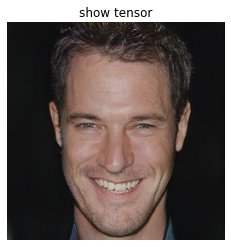

In [4]:
img0_tsr = torch.tensor(img0).unsqueeze(0).permute(0,3,1,2) # 1 x 3 x height x width 
img_size = 256 # 128
img0_tsr = torch.nn.functional.interpolate(img0_tsr, size=(img_size,img_size), mode='bilinear')
print(img0_tsr.shape)

plt.imshow(img0_tsr[0].permute(1,2,0))
plt.title("show tensor")
plt.axis("off");


Text(0.5, 1.0, 'Ground Truth -- Noisy data')

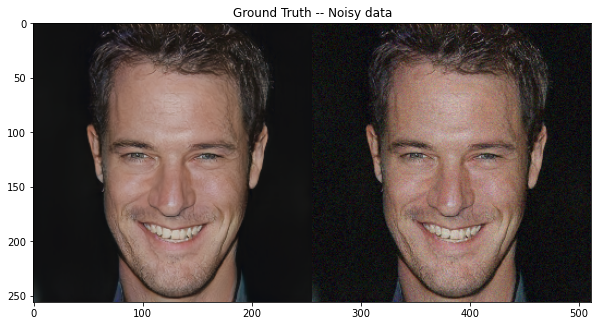

In [5]:
img_tsr = img0_tsr.clone() + 8./255. * torch.randn_like(img0_tsr)
img_tsr = torch.clamp(img_tsr,0.,1.)

H = img_tsr.size(2)
W = img_tsr.size(3)

plt.figure(figsize = (10,10))
plt.imshow(torch.cat((img0_tsr,img_tsr),3).squeeze(0).permute(1,2,0))
plt.title("Ground Truth -- Noisy data")

### selection of an interest point for comparison

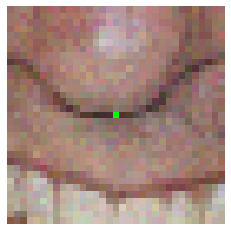

In [6]:
point = np.array([710,510]) # bout du nez
#point = np.array([502,845]) # bord oreille
                 
interest_point = (point/1024.* img_size).astype(int)
index_interest_point = interest_point[0]*W+interest_point[1]

patch_ori = img_tsr[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0).clone() # do not forget clone() !
patch_ori[:,16,16] = torch.tensor([0,1,0])
patch_ori = patch_ori.permute(1,2,0)
plt.imshow(patch_ori)
plt.axis("off");

## 1 - Gaussian filtering with nn.functional.conv1d

torch.Size([1, 3, 256, 256])


(-0.5, 767.5, 255.5, -0.5)

<Figure size 720x720 with 0 Axes>

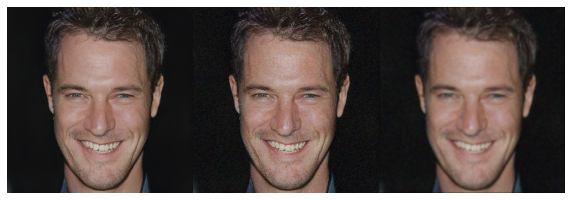

In [7]:
sig_pix = 1.0
# definition du noyau gaussien 1D
k = int(3 * sig_pix)
x = torch.arange(-k,k+1,1) # size : 2k+1
g = 1./np.sqrt(2*np.pi) / sig_pix * torch.exp( - x**2 / (2 * sig_pix**2))
#print(g.sum())
g /= g.sum()
#plt.plot(g)
g = g.reshape(1,1,2*k+1,1)
#print(g.shape)

# convolution ... but not with torch.nn.Conv1d() !
if True  : # process color channels as a batch
    img_tsr_gauss_xy = img_tsr.clone().view(3,1,img_tsr.size(2),img_tsr.size(3))
    img_tsr_gauss_xy = torch.nn.functional.conv1d(img_tsr_gauss_xy, g, stride=1, padding=(k,0))
    img_tsr_gauss_xy = torch.nn.functional.conv1d(img_tsr_gauss_xy, g.view(1,1,1,-1), stride=1, padding=(0,k))
    img_tsr_gauss_xy = img_tsr_gauss_xy.view(1,3,img_tsr.size(2),img_tsr.size(3))

else : # process each color channel 
    img_tsr_gauss_x = img_tsr.clone()
    for i in range(3) : # convolution on each channel along columns
        G = torch.zeros((1,3,2*k+1,1))  
        G[:,i,...] = g
        res = torch.nn.functional.conv1d(img_tsr_gauss_x, G, stride=1, padding=(k,0)) # with zero padding on columns to preserve shape
        img_tsr_gauss_x[:,i,...] = res

    g = g.reshape(1,1,1,2*k+1)
    img_tsr_gauss_xy = img_tsr_gauss_x
    del img_tsr_gauss_x
    for i in range(3) : # convolution on each channel along lines
        G = torch.zeros((1,3,1,2*k+1))  
        G[:,i,...] = g
        res = torch.nn.functional.conv1d(img_tsr_gauss_xy, G, stride=1, padding=(0,k)) # with zero padding on lines to preserve shape
        img_tsr_gauss_xy[:,i,...] = res
print(img_tsr_gauss_xy.shape)

res = torch.cat((img0_tsr,img_tsr,img_tsr_gauss_xy),axis=3)
plt.figure(figsize = (10,10))
plt.figure(figsize = (10,10))
plt.imshow(res.squeeze(0).permute(1,2,0))
plt.axis("off")

(-0.5, 65.5, 32.5, -0.5)

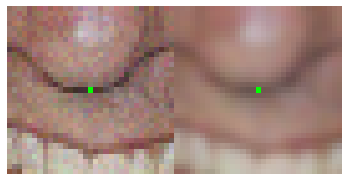

In [8]:
patch_gauss = img_tsr_gauss_xy[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0).clone()
patch_gauss[:,16,16] = torch.tensor([0,1,0]) # pixel vert
patch_gauss = patch_gauss.permute(1,2,0) 
plt.imshow(torch.cat((patch_ori,patch_gauss), 1))
plt.axis("off")

## 2 - Bilateral Filtering

### Naive implementation with 4 nested loops (slooooow)

In [9]:
if False :
    sig_pix = 20.
    sig_col = 100./255.
    half_win_size = 1

    H = img_tsr.size(2)
    W = img_tsr.size(3)

    img_bilateral = torch.zeros_like(img_tsr)
    total_weights = torch.zeros_like(img_bilateral)
    for i in range(H) :
        for j in range(W) :

            for dx in range(-half_win_size,half_win_size+1,1) :
                idx = i+dx
                idx = np.clip(idx,0,H-1)
                wx_pix = np.exp(-(dx/sig_pix)**2/2.)
                
                if True :
                    for dy in range(-half_win_size,half_win_size+1,1) :
                        jdy = j+dy
                        jdy = np.clip(jdy,0,W-1)
                        wy_pix = np.exp(-(dy/sig_pix)**2/2.)

                        w_color = torch.exp(-torch.sum(((img_tsr[:,:,i,j] - img_tsr[:,:,idx,jdy])/sig_col)**2)/2.)
                        weight = wx_pix * wy_pix * w_color

                        total_weights[:,:,i,j] = weight
                        img_bilateral[:,:,i,j] = img_tsr[:,:,idx,jdy] * weight 

    img_bilateral /= total_weights

    diff = (img_bilateral - img_tsr) # in [-1,1]
    diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
    res_bilateral = torch.cat((img0_tsr,img_tsr,img_bilateral,diff),axis=3)

    plt.figure(figsize=(20,20))
    plt.imshow(res_bilateral.squeeze(0).permute(1,2,0))
    plt.title(" bilateral filtering")
    plt.axis("off")

### faster code using slicing

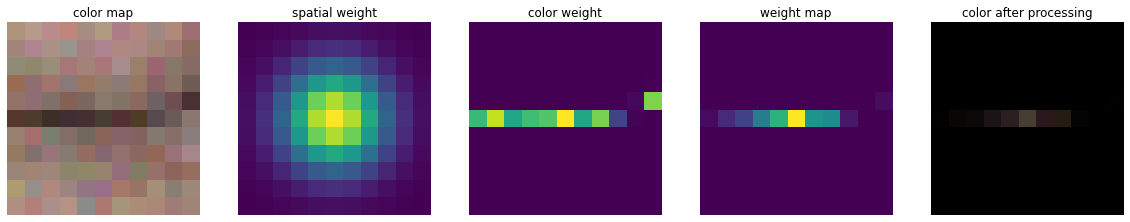

In [10]:
# parameters
half_win_size = 5
win_size = 2*half_win_size+1
sig_pix = 2.
sig_col = 20./255.

# init
img_bilateral = torch.zeros_like(img_tsr)


# precomputation
dx = torch.arange(-half_win_size,half_win_size+1,1) # win_size
weight_pix = torch.exp(-(dx/sig_pix)**2 / 2.).reshape(1,1,-1,1)
weight_pix = weight_pix * weight_pix.reshape(1,1,1,-1) # 1 x 1 x win_size x win_size

#plt.imshow(weight_pix.squeeze(0).permute(1,2,0).squeeze(2).numpy())

for i in range(H) :
    idx = i + dx
    idx = np.clip(idx,0,H-1)

    for j in range(W) :
        jdx = j + dx
        jdx = np.clip(jdx,0,W-1)

        color = img_tsr[:,:,idx][:,:,:,jdx]
        weight_color = torch.exp(-torch.sum((color - img_tsr[:,:,i:i+1,j:j+1])**2,1)/2./sig_col**2)
        weight = weight_color * weight_pix

        post_color = color * weight
        img_bilateral[:,:,i,j] = torch.sum( post_color.view(1,3,-1), 2) / torch.sum(weight)

        if (i==interest_point[0] and j==interest_point[1]) :
            img_bilateral[:,:,i,j] = torch.tensor([0,1,0]) # pixel vert

            fig, ax = plt.subplots(1,5, figsize=(20, 20))
            ax[0].imshow(color.squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map"); ax[0].axis("off")
            ax[1].imshow(weight_pix.squeeze(0).permute(1,2,0)); ax[1].set_title("spatial weight"); ax[1].axis("off")
            ax[2].imshow(weight_color.squeeze(0)); ax[2].set_title("color weight"); ax[2].axis("off")
            ax[3].imshow(weight.squeeze(0).permute(1,2,0)); ax[3].set_title("weight map"); ax[3].axis("off")
            ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing"); ax[4].axis("off")
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

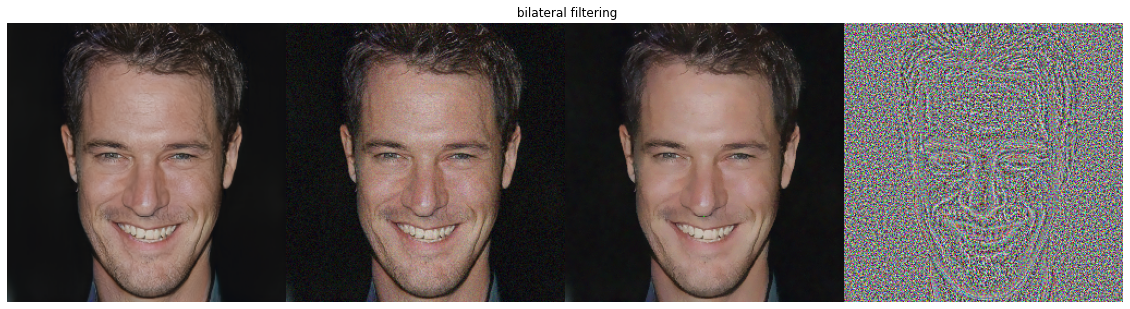

In [11]:
diff = (img_bilateral - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_bilateral = torch.cat((img0_tsr,img_tsr,img_bilateral,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_bilateral.squeeze(0).permute(1,2,0))
plt.title(" bilateral filtering")
plt.axis("off")

### using fold / unfold

(-0.5, 255.5, 255.5, -0.5)

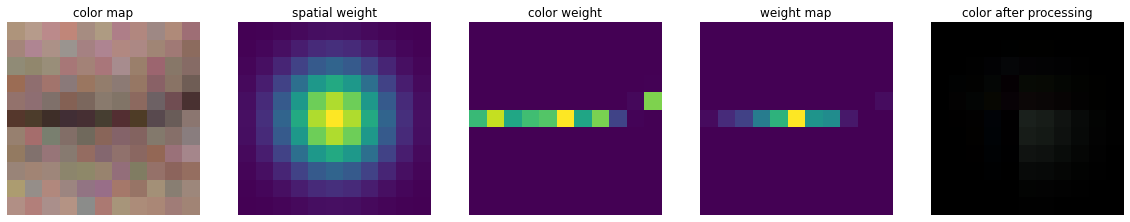

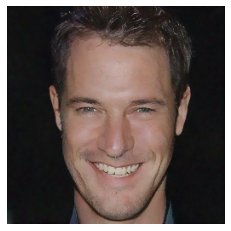

In [12]:
# parameters
half_win_size = 5
win_size = 2*half_win_size+1
sig_pix = 2.
sig_col = 20./255.

d = win_size**2 # patch dim
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# precomputation
dx = torch.arange(-half_win_size,half_win_size+1,1) # win_size
weight_pix = torch.exp(-(dx/float(sig_pix))**2 / 2.).reshape(1,1,-1,1)
weight_pix = weight_pix * weight_pix.reshape(1,1,1,-1) # 1 x 1 x win_size x win_size
weight_pix = weight_pix.view(1,-1,1)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=win_size, dilation=1, padding=half_win_size, stride=1)(img_tsr.view(3,1,img_tsr.size(2),img_tsr.size(3))) # 3 x d x N (color channels as batch)

pix_center = win_size**2//2
patch_diff = patch - patch[:,pix_center:pix_center+1,:] # pixel central du patch = couleur du pixel à traiter
weight_color = torch.exp( - torch.sum(patch_diff**2, 0, keepdim=True) /2. /float(sig_col)**2 )
weight = weight_pix * weight_color

#plt.imshow(weight_color[:,:,index_interest_point].view(win_size,win_size))

if True : # on moyenne pour obtenir la valeur du pixel central
    synth = torch.sum(patch * weight, 1, keepdim=True) / torch.sum(weight, 1, keepdim=True)

else : # TEST aggregation de patch (moyenne) comme pour NL MEANS
    patch_bilateral = patch_bilateral * weight

    normalisation

    # sum overlapping patch
    synth = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), win_size, dilation=1, padding=half_win_size, stride=1)(patch_bilateral)
    # normalisation by number of overlapping patch
    synth /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), win_size, dilation=1, padding=half_win_size, stride=1)(torch.ones_like(patch_bilateral))

synth[:,:,index_interest_point] = torch.tensor([0.,1.,0.]).view(3,1)
synth = synth.view(1,3,img_tsr.size(2),img_tsr.size(3))

fig, ax = plt.subplots(1,5, figsize=(20, 20))
ax[0].imshow(patch[:,:,index_interest_point].view(3,win_size,win_size).squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map"); ax[0].axis("off")
ax[1].imshow(weight_pix.view(win_size,win_size)); ax[1].set_title("spatial weight"); ax[1].axis("off")
ax[2].imshow(weight_color[:,:,index_interest_point].view(win_size,win_size)); ax[2].set_title("color weight"); ax[2].axis("off")
ax[3].imshow(weight[:,:,index_interest_point].view(win_size,win_size)); ax[3].set_title("weight map"); ax[3].axis("off")
ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing"); ax[4].axis("off")

plt.figure()
plt.imshow(synth.squeeze(0).permute(1,2,0))
plt.axis("off")


(-0.5, 98.5, 32.5, -0.5)

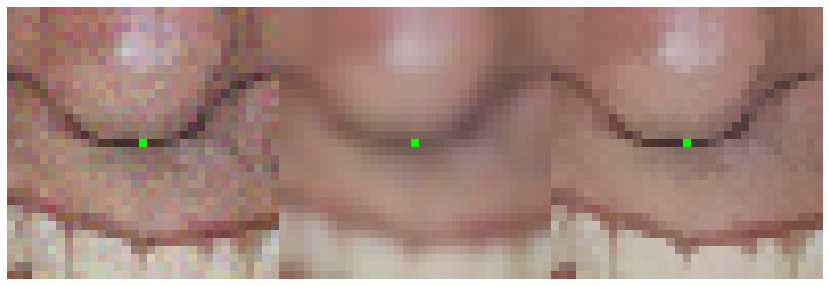

In [13]:
patch_bilateral = synth[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_bilateral[:,16,16] = torch.tensor([0,1,0])
patch_bilateral = patch_bilateral.permute(1,2,0) 
plt.figure(figsize=(15,5))
plt.imshow(torch.cat((patch_ori,patch_gauss,patch_bilateral), 1))
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

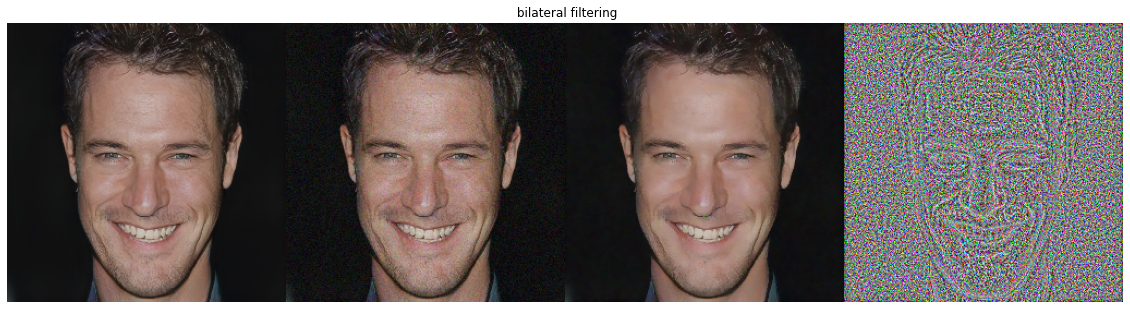

In [14]:
diff = (synth - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_bilateral = torch.cat((img0_tsr,img_tsr,synth,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_bilateral.squeeze(0).permute(1,2,0))
plt.title(" bilateral filtering")
plt.axis("off")

## 3 - Joint / Cross - Bilateral Filtering

see Eisemann and Durand [2004] and Petschnigg et al. [2004] 

(-0.5, 255.5, 255.5, -0.5)

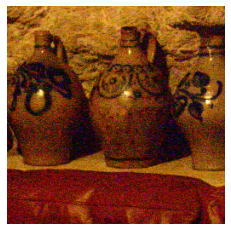

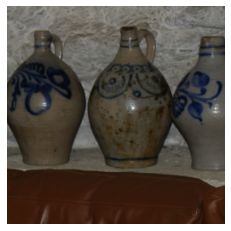

In [15]:
# load image pair

file_name0 = 'cave-noflash.bmp' #'cakeNo-flash.jpg' 
file_name1 = 'cave-flash.bmp' # 'cakeFlash.jpg' 

im0 = plt.imread(file_name0)
im1 = plt.imread(file_name1)
if im0.max() > 1. : im0 = im0 / 255.
if im1.max() > 1. : im1 = im1 / 255.

im0 = torch.tensor(im0).unsqueeze(0).permute(0,3,1,2) # 1 x 3 x height x width 
im1 = torch.tensor(im1).unsqueeze(0).permute(0,3,1,2) # 1 x 3 x height x width 

im_size = 256
im0 = torch.nn.functional.interpolate(im0, size=(im_size,im_size), mode='bilinear')
im1 = torch.nn.functional.interpolate(im1, size=(im_size,im_size), mode='bilinear')


plt.figure()
plt.imshow(im0[0].permute(1,2,0)); plt.axis("off")
plt.figure()
plt.imshow(im1[0].permute(1,2,0)); plt.axis("off")




(-0.5, 255.5, 255.5, -0.5)

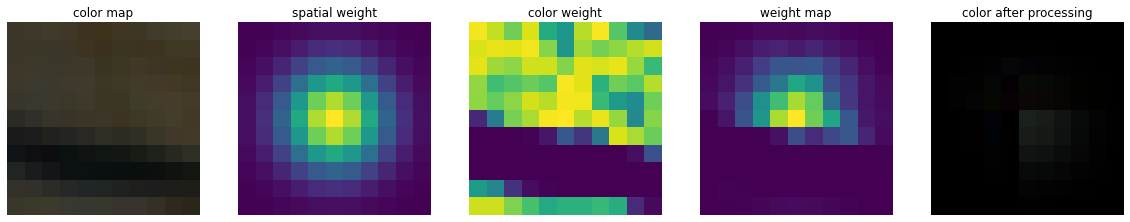

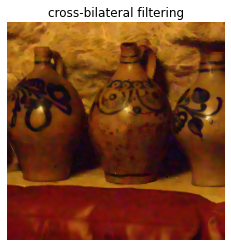

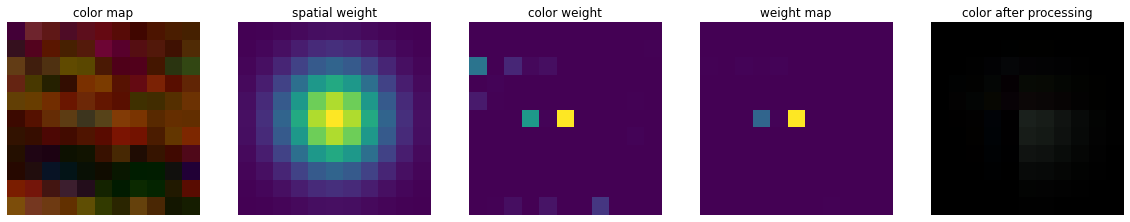

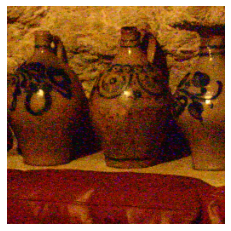

In [16]:
# parameters
half_win_size = 5
win_size = 2*half_win_size+1
sig_pix = 2.
sig_col = 10./255.

d = win_size**2 # patch dim
N = im0.size(2) * im0.size(3) # number of patch (= Number of pixels with appropriate padding)

# precomputation
dx = torch.arange(-half_win_size,half_win_size+1,1) # win_size
weight_pix = torch.exp(-(dx/float(sig_pix))**2 / 2.).reshape(1,1,-1,1)
weight_pix = weight_pix * weight_pix.reshape(1,1,1,-1) # 1 x 1 x win_size x win_size
weight_pix = weight_pix.view(1,-1,1)

# overlapping patch decomposition (sliding window)
patch0 = torch.nn.Unfold(kernel_size=win_size, dilation=1, padding=half_win_size, stride=1)(im0.view(3,1,im0.size(2),im0.size(3))) # 3 x d x N (color channels as batch)
patch1 = torch.nn.Unfold(kernel_size=win_size, dilation=1, padding=half_win_size, stride=1)(im1.view(3,1,im1.size(2),im1.size(3))) # 3 x d x N (color channels as batch)

# cross bilateral filtering
pix_center = win_size**2//2
patch_diff = patch1 - patch1[:,pix_center:pix_center+1,:] # pixel central du patch = couleur du pixel à traiter
weight_color = torch.exp( - torch.sum(patch_diff**2, 0, keepdim=True) /2. /float(sig_col)**2 )
weight = weight_pix * weight_color

synth01 = torch.sum(patch0 * weight, 1, keepdim=True) / torch.sum(weight, 1, keepdim=True)

synth01[:,:,index_interest_point] = torch.tensor([0.,1.,0.]).view(3,1)
synth01 = synth01.view(1,3,im0.size(2),im0.size(3))

fig, ax = plt.subplots(1,5, figsize=(20, 20))
ax[0].imshow(patch1[:,:,index_interest_point].view(3,win_size,win_size).squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map"); ax[0].axis("off")
ax[1].imshow(weight_pix.view(win_size,win_size)); ax[1].set_title("spatial weight"); ax[1].axis("off")
ax[2].imshow(weight_color[:,:,index_interest_point].view(win_size,win_size)); ax[2].set_title("color weight"); ax[2].axis("off")
ax[3].imshow(weight[:,:,index_interest_point].view(win_size,win_size)); ax[3].set_title("weight map"); ax[3].axis("off")
ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing"); ax[4].axis("off")

plt.figure()
plt.imshow(synth01.squeeze(0).permute(1,2,0))
plt.title('cross-bilateral filtering'); plt.axis("off")


# simple bilateral filtering
pix_center = win_size**2//2
patch_diff = patch0 - patch0[:,pix_center:pix_center+1,:] # pixel central du patch = couleur du pixel à traiter
weight_color = torch.exp( - torch.sum(patch_diff**2, 0, keepdim=True) /2. /float(sig_col)**2 )
weight = weight_pix * weight_color

synth0 = torch.sum(patch0 * weight, 1, keepdim=True) / torch.sum(weight, 1, keepdim=True)

synth0[:,:,index_interest_point] = torch.tensor([0.,1.,0.]).view(3,1)
synth0 = synth0.view(1,3,im0.size(2),im0.size(3))


fig, ax = plt.subplots(1,5, figsize=(20, 20))
ax[0].imshow(patch0[:,:,index_interest_point].view(3,win_size,win_size).squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map"); ax[0].axis("off")
ax[1].imshow(weight_pix.view(win_size,win_size)); ax[1].set_title("spatial weight"); ax[1].axis("off")
ax[2].imshow(weight_color[:,:,index_interest_point].view(win_size,win_size)); ax[2].set_title("color weight"); ax[2].axis("off")
ax[3].imshow(weight[:,:,index_interest_point].view(win_size,win_size)); ax[3].set_title("weight map"); ax[3].axis("off")
ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing"); ax[4].axis("off")

plt.figure()
plt.imshow(synth0.squeeze(0).permute(1,2,0))
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

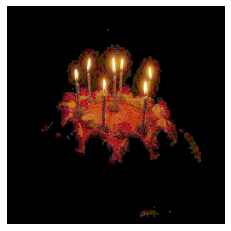

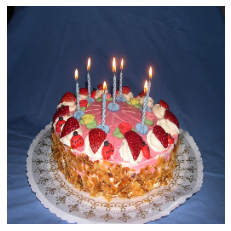

In [17]:
# load image pair

file_name0 = 'cakeNo-flash.jpg' 
file_name1 = 'cakeFlash.jpg' 

im0 = plt.imread(file_name0)
im1 = plt.imread(file_name1)
if im0.max() > 1. : im0 = im0 / 255.
if im1.max() > 1. : im1 = im1 / 255.

im0 = torch.tensor(im0).unsqueeze(0).permute(0,3,1,2) # 1 x 3 x height x width 
im1 = torch.tensor(im1).unsqueeze(0).permute(0,3,1,2) # 1 x 3 x height x width 

im_size = 256
im0 = torch.nn.functional.interpolate(im0, size=(im_size,im_size), mode='bilinear')
im1 = torch.nn.functional.interpolate(im1, size=(im_size,im_size), mode='bilinear')

# improve color gammut for the no-flash image
im0 = im0**(0.3)

plt.figure()
plt.imshow(im0[0].permute(1,2,0)); plt.axis("off")
plt.figure()
plt.imshow(im1[0].permute(1,2,0)); plt.axis("off")


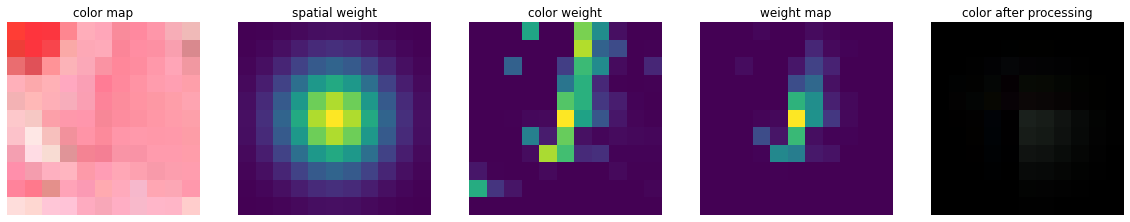

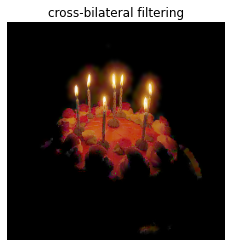

In [18]:
# parameters
half_win_size = 5
win_size = 2*half_win_size+1
sig_pix = 2.
sig_col = 10./255.

d = win_size**2 # patch dim
N = im0.size(2) * im0.size(3) # number of patch (= Number of pixels with appropriate padding)

# precomputation
dx = torch.arange(-half_win_size,half_win_size+1,1) # win_size
weight_pix = torch.exp(-(dx/float(sig_pix))**2 / 2.).reshape(1,1,-1,1)
weight_pix = weight_pix * weight_pix.reshape(1,1,1,-1) # 1 x 1 x win_size x win_size
weight_pix = weight_pix.view(1,-1,1)

# overlapping patch decomposition (sliding window)
patch0 = torch.nn.Unfold(kernel_size=win_size, dilation=1, padding=half_win_size, stride=1)(im0.view(3,1,im0.size(2),im0.size(3))) # 3 x d x N (color channels as batch)
patch1 = torch.nn.Unfold(kernel_size=win_size, dilation=1, padding=half_win_size, stride=1)(im1.view(3,1,im1.size(2),im1.size(3))) # 3 x d x N (color channels as batch)

# cross bilateral filtering
pix_center = win_size**2//2
patch_diff = patch1 - patch1[:,pix_center:pix_center+1,:] # pixel central du patch = couleur du pixel à traiter
weight_color = torch.exp( - torch.sum(patch_diff**2, 0, keepdim=True) /2. /float(sig_col)**2 )
weight = weight_pix * weight_color

synth01 = torch.sum(patch0 * weight, 1, keepdim=True) / torch.sum(weight, 1, keepdim=True)

synth01[:,:,index_interest_point] = torch.tensor([0.,1.,0.]).view(3,1)
synth01 = synth01.view(1,3,im0.size(2),im0.size(3))

fig, ax = plt.subplots(1,5, figsize=(20, 20))
ax[0].imshow(patch1[:,:,index_interest_point].view(3,win_size,win_size).squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map"); ax[0].axis("off")
ax[1].imshow(weight_pix.view(win_size,win_size)); ax[1].set_title("spatial weight"); ax[1].axis("off")
ax[2].imshow(weight_color[:,:,index_interest_point].view(win_size,win_size)); ax[2].set_title("color weight"); ax[2].axis("off")
ax[3].imshow(weight[:,:,index_interest_point].view(win_size,win_size)); ax[3].set_title("weight map"); ax[3].axis("off")
ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing"); ax[4].axis("off")

plt.figure()
plt.imshow(synth01.squeeze(0).permute(1,2,0))
plt.title('cross-bilateral filtering'); plt.axis("off")


if False :# comparison simple bilateral filtering
    pix_center = win_size**2//2
    patch_diff = patch0 - patch0[:,pix_center:pix_center+1,:] # pixel central du patch = couleur du pixel à traiter
    weight_color = torch.exp( - torch.sum(patch_diff**2, 0, keepdim=True) /2. /float(sig_col)**2 )
    weight = weight_pix * weight_color

    synth0 = torch.sum(patch0 * weight, 1, keepdim=True) / torch.sum(weight, 1, keepdim=True)

    synth0[:,:,index_interest_point] = torch.tensor([0.,1.,0.]).view(3,1)
    synth0 = synth0.view(1,3,im0.size(2),im0.size(3))


    fig, ax = plt.subplots(1,5, figsize=(20, 20))
    ax[0].imshow(patch0[:,:,index_interest_point].view(3,win_size,win_size).squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map")
    ax[1].imshow(weight_pix.view(win_size,win_size)); ax[1].set_title("spatial weight")
    ax[2].imshow(weight_color[:,:,index_interest_point].view(win_size,win_size)); ax[2].set_title("color weight")
    ax[3].imshow(weight[:,:,index_interest_point].view(win_size,win_size)); ax[3].set_title("weight map")
    ax[4].imshow(post_color.squeeze(0).permute(1,2,0)); ax[4].set_title("color after processing")

    plt.figure()
    plt.imshow(synth0.squeeze(0).permute(1,2,0)); plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

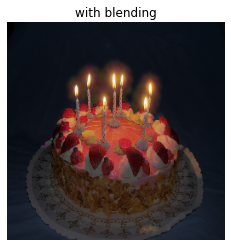

In [19]:
# HDR blending
alpha = .3
x = alpha * im1 + (1.-alpha) * synth01
plt.figure()
plt.imshow(x.squeeze(0).permute(1,2,0))
plt.title('with blending'); plt.axis("off")


## 4 - Non Local Filtering



torch.Size([1, 27, 65536])


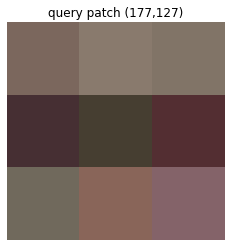

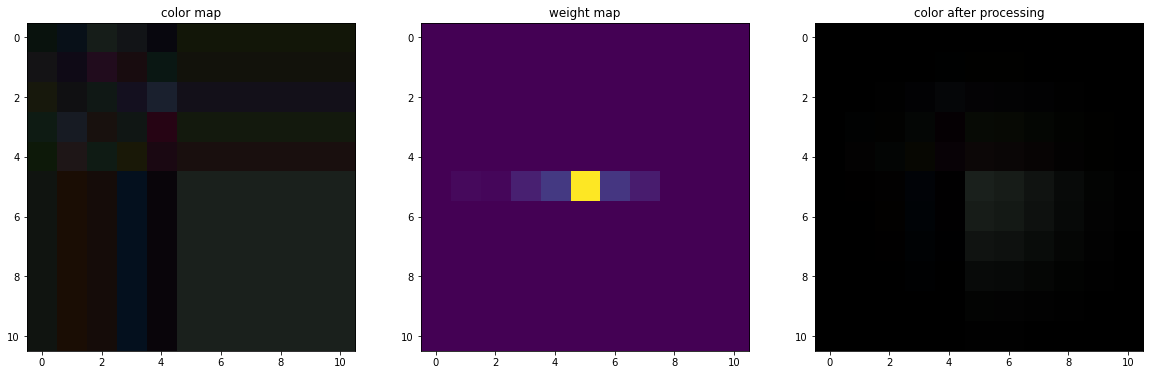

In [20]:
# parameters
half_patch_size = 1
patch_size = 2*half_patch_size+1
half_win_size = 5
win_size = 2*half_win_size+1

sigma = 10./255. * patch_size

d = 3*patch_size**2 # patch dim
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=patch_size, dilation=1, padding=half_patch_size, stride=1)(img_tsr) # 1 x d x N (no batch)
print(patch.shape)

if False : # naive coding, computing distance between ALL patches (self attention dot-product)
    # HUGE N-by-N MATRIX distance computation 
    patch_dist  =  (patch**2).sum(1).view(1,1,N,1) # norme patch queries
    patch_dist +=  patch_dist.view(1,1,1,N) # norme patch keys
    patch_dist += -2. * patch.permute(0,2,1).view(1,N,d) @ patch
    
    weight_patch = torch.exp( - patch_dist /2. /float(sigma)**2 )  # 1 x 1 x N x N
    plt.imshow(weight_patch[:,:,:,95*128+58].view(H,W))

    synth = patch @ weight_patch.view(1,N,N) / weight_patch.sum()

else : # with neighborhood search restriction (win_size x win_size search)
    synth = torch.zeros_like(patch)
    dx = torch.arange(-half_win_size,half_win_size+1,1)
    dx, dy = torch.meshgrid(dx, dx)
    for i in range(N) :
        # fetch query patch at index i
        query = patch[:,:,i].unsqueeze(2).clone() # [1 x d x 1]

        # (x,y) : 2D patch coordinates : i = x * W + y
        x = i // W
        y = i % W

        # extraction of patchs in neighborhood [win_size x win_size]
        xx = np.clip(x+dx,0,H-1) 
        yy = np.clip(y+dy,0,W-1)
        I = xx * W + yy # 1D coordinates
        p = patch[0:1,:,I].clone() # [1 x d x win_size x win_size]
        p = p.view(1,d,win_size**2) # 1 x d x N'

        # distance computation
        patch_dist = (query**2).sum(1).view(1,1,1) # norm  of patch queries
        patch_dist = patch_dist + (p**2).sum(1).view(1,1,-1)  # norm of patch keys
        patch_dist -= 2. * torch.matmul(query.view(1,1,d), p) # [1 1 N']

        # weighted mean
        weight_patch = torch.exp( - patch_dist /2. /float(sigma)**2 )  # 1 x 1 x N'
        synth[:,:,i:i+1] = torch.sum(weight_patch * p, 2, keepdim=True) / torch.sum(weight_patch, 2, keepdim=True)

        if (x==interest_point[0] and y==interest_point[1]) :
            query = query.view(3,patch_size,patch_size)
            plt.imshow(query.permute(1,2,0).numpy())
            plt.title(f"query patch ({x},{y})"); plt.axis("off")

            weight_patch = weight_patch.view(win_size,win_size)
            #weight_patch[half_win_size, half_win_size] = 0 # discard self comparison
            
            fig, ax = plt.subplots(1,3, figsize=(20, 20))
            ax[0].imshow(color.squeeze(0).permute(1,2,0).squeeze(2)); ax[0].set_title("color map")
            ax[1].imshow(weight_patch.view(win_size,win_size)); ax[1].set_title("weight map")
            ax[2].imshow(post_color.squeeze(0).permute(1,2,0)); ax[2].set_title("color after processing")

if False : # aggregation de patch (moyenne) 
    # sum overlapping patch
    synth = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(synth)
    # normalisation by number of overlapping patch
    synth /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch))
else : # extraction of central pixel
    n = patch_size**2
    color_center = [n*c + n//2  for c in range(3)]
    synth = synth[:,color_center,:]
    synth = synth.view(1,3,H,W)

# show green pixel of interest
x=interest_point[0]; y=interest_point[1]
synth[:,:,x,y] = torch.tensor([0.,1.,0.]).view(1,3)

#plt.figure(); plt.imshow(synth.squeeze(0).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

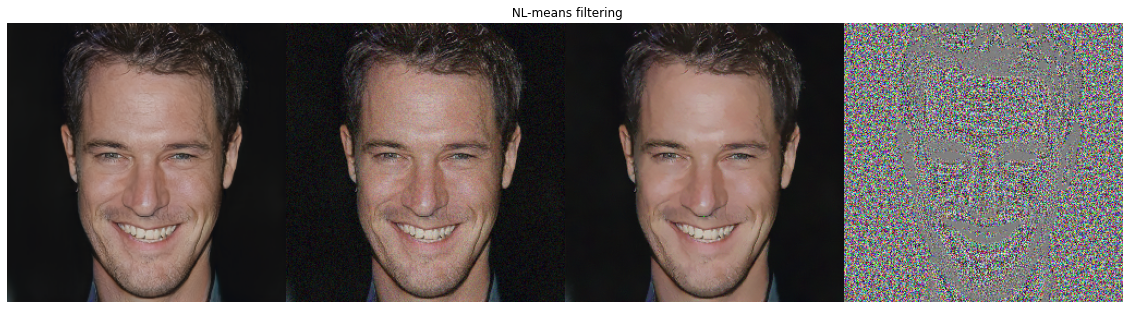

In [47]:
diff = (synth - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_NLmeans = torch.cat((img0_tsr,img_tsr,synth,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_NLmeans.squeeze(0).permute(1,2,0))
plt.title(" NL-means filtering")
plt.axis("off")

(-0.5, 131.5, 32.5, -0.5)

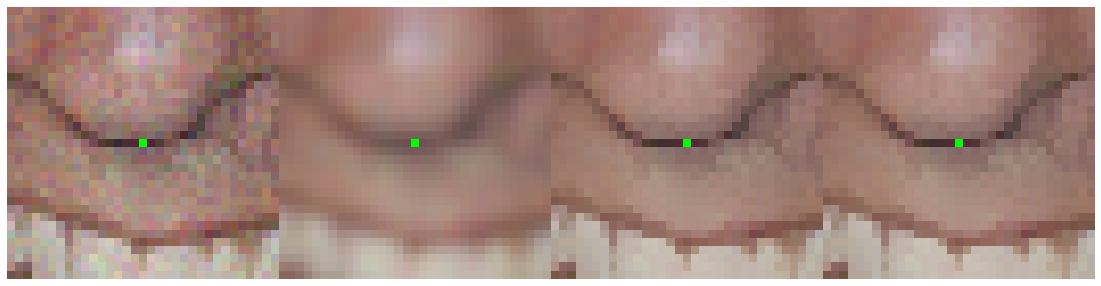

In [61]:
patch_NLM = synth[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_NLM[:,16,16] = torch.tensor([0,1,0])
patch_NLM = patch_NLM.permute(1,2,0) 
plt.figure(figsize=(20,5))
plt.imshow(torch.cat((patch_ori,patch_gauss,patch_bilateral,patch_NLM), 1)); plt.axis("off")

#### Calcul PSNR / MSE

In [49]:
"to do"

'to do'

## 4.2 fast Non-Local PCA

In [21]:
# parameters
half_patch_size = 1
patch_size = 2*half_patch_size+1
half_win_size = 5
win_size = 2*half_win_size+1

sigma = torch.tensor(5./255. * patch_size)

d = 3*patch_size**2 # patch dim
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=patch_size, dilation=1, padding=half_patch_size, stride=1)(img_tsr) # 1 x d x N (no batch)

# computes mean, covariance
patch_mean = torch.mean(patch, 2, keepdim=True)
patch_centered = (patch - patch_mean)
patch_cov = torch.bmm(patch_centered, patch_centered.transpose(2,1)) / (patch.size(2)) # unbiaised estimate

# compute PCA
#patch_eig, patch_vect = torch.eig(patch_cov.view(d,d), eigenvectors=True) # imaginary part is 0 for patch_eig
patch_eig, patch_vect = torch.symeig(patch_cov.view(d,d), eigenvectors=True) # for symmetric matrix

In [22]:
# filtering function
identity =  lambda val, thres : val
hard_thres = lambda val, thres : val * (abs(val) > thres)  # val if (val > thres) else torch.tensor(0.)
soft_thres = lambda val, thres : torch.sign(val) * torch.max(abs(val) - thres, torch.tensor(0.)) 

torch.Size([1769472])


Text(0.5, 1.0, 'projection on eigen vectors')

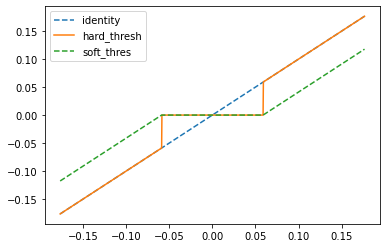

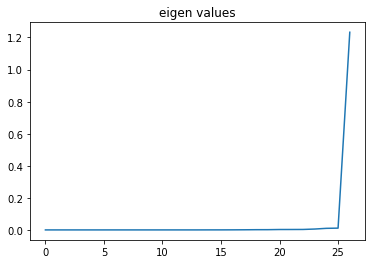

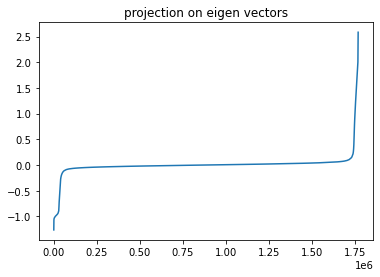

In [23]:
x = torch.linspace(-3*sigma,sigma*3,1000)
t = torch.tensor(1.)
plt.figure()
plt.plot(x, identity(x,sigma), '--')
plt.plot(x, hard_thres(x,sigma), '-')
plt.plot(x, soft_thres(x,sigma), '--')
#plt.plot(patch_eig, -1 + torch.zeros_like(patch_eig), 'x')
plt.legend(['identity', 'hard_thresh', 'soft_thres', 'eigenvalues'])

plt.figure()
plt.plot(patch_eig)
plt.title("eigen values")

val = patch_vect.transpose(1,0) @ patch_centered.squeeze(0)
val = val.view(-1)
val, _ = val.sort()
plt.figure()
plt.plot(val)
print(val.shape)
plt.title("projection on eigen vectors")

In [24]:
#thres_fun = identity
#thres_fun = hard_thres
thres_fun = soft_thres

# perform filtering and reconstruction of patch
patch_NLPCA = patch_mean + ( patch_vect @ thres_fun( patch_vect.transpose(1,0) @ patch_centered.squeeze(0), sigma ) ).unsqueeze(0)

In [25]:
# aggregation of patches (actual averaging of patch) 
# sum overlapping patch
synth_NLPCA = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(patch_NLPCA)
# normalisation by number of overlapping patch
synth_NLPCA /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

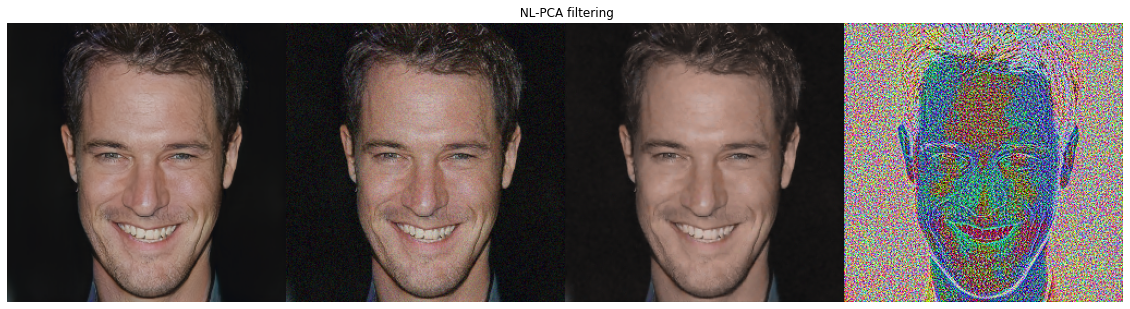

In [55]:
diff = (synth_NLPCA - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_NLPCA = torch.cat((img0_tsr,img_tsr,synth_NLPCA,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_NLPCA.squeeze(0).permute(1,2,0))
plt.title(" NL-PCA filtering")
plt.axis("off")

In [56]:
"to do : change colorspace"

'to do : change colorspace'

Text(0.5, 1.0, 'noisy / bilateral / NL means / NL PCA')

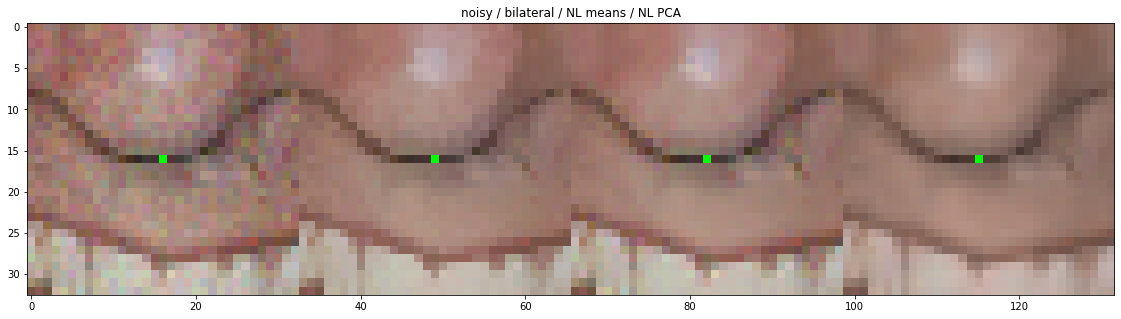

In [57]:
patch_NLPCA = synth_NLPCA[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_NLPCA[:,16,16] = torch.tensor([0,1,0])
patch_NLPCA = patch_NLPCA.permute(1,2,0) 
plt.figure(figsize=(20,5))
plt.imshow(torch.cat((patch_ori,patch_bilateral,patch_NLM,patch_NLPCA), 1))
plt.title("noisy / bilateral / NL means / NL PCA")

## Non Local PCA (color batch version)
### color channels are processed as a batch dimension

In [58]:
# parameters
half_patch_size = 1
patch_size = 2*half_patch_size+1
half_win_size = 5
win_size = 2*half_win_size+1

sigma = torch.tensor(10./255. * patch_size)

d = patch_size**2 # patch dim (no colors)
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=patch_size, dilation=1, padding=half_patch_size, stride=1)(img_tsr.view(3,1,img_tsr.size(2), img_tsr.size(3))) # 3 x d x N (with batch)

# computes mean, covariance
patch_mean = torch.mean(patch, 2, keepdim=True)
patch_centered = (patch - patch_mean)
patch_cov = torch.bmm(patch_centered, patch_centered.transpose(2,1)) / (patch.size(2)) # unbiaised estimate

# compute PCA
patch_eig = []
patch_vect = []
for c in range(3) :
    C = patch_cov[c] # d x d
    C_eig, V_eig = torch.symeig(C, eigenvectors=True) # for symmetric matrix
    patch_eig.append(C_eig)
    patch_vect.append(V_eig)

# filtering function
identity =  lambda val, thres : val
hard_thres = lambda val, thres : val * (abs(val) > thres)  # val if (val > thres) else torch.tensor(0.)
soft_thres = lambda val, thres : torch.sign(val) * torch.max(abs(val) - thres, torch.tensor(0.)) 

thres_fun = hard_thres # soft_thres

# perform filtering and reconstruction of patch
patch_NLPCA2 = torch.zeros_like(patch)
for c in range(3) :
    patch_NLPCA2[c] = patch_mean[c] + ( patch_vect[c] @ thres_fun( patch_vect[c].transpose(1,0) @ patch_centered[c].squeeze(0), sigma ) ).unsqueeze(0)

# aggregation of patches (actual averaging of patch) 
# sum overlapping patch
synth_NLPCA2 = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(patch_NLPCA2)
# normalisation by number of overlapping patch
synth_NLPCA2 /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch))

synth_NLPCA2 = synth_NLPCA2.view(1,3,img_tsr.size(2),img_tsr.size(3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

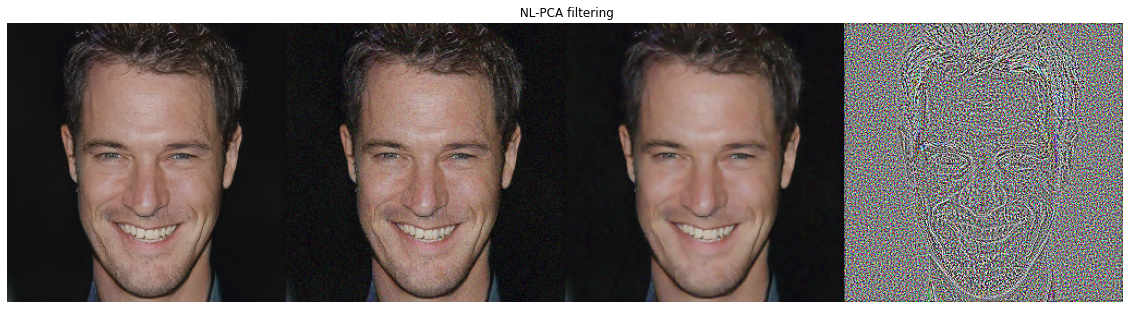

In [59]:
diff = (synth_NLPCA2 - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_NLPCA = torch.cat((img0_tsr,img_tsr,synth_NLPCA2,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_NLPCA.squeeze(0).permute(1,2,0))
plt.title(" NL-PCA filtering")
plt.axis("off")

Text(0.5, 1.0, 'noisy / NL means / NL PCA /  NL PCA (batch color)')

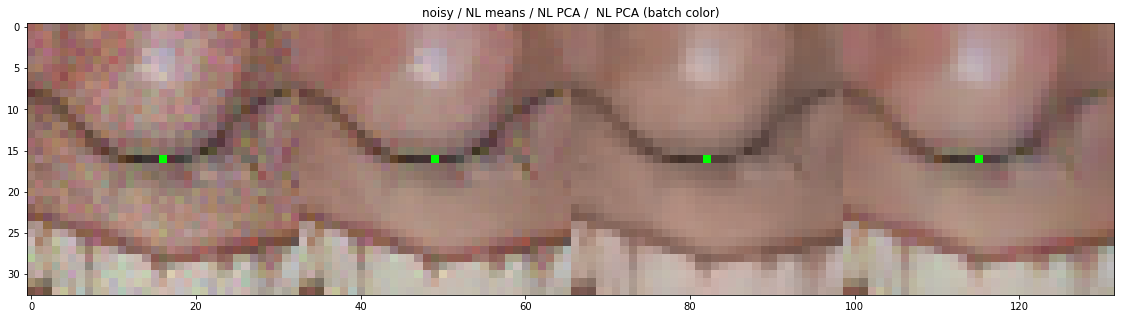

In [60]:
patch_NLPCA2 = synth_NLPCA2[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_NLPCA2[:,16,16] = torch.tensor([0,1,0])
patch_NLPCA2 = patch_NLPCA2.permute(1,2,0) 
plt.figure(figsize=(20,5))
plt.imshow(torch.cat((patch_ori,patch_NLM,patch_NLPCA,patch_NLPCA2), 1))
plt.title("noisy / NL means / NL PCA /  NL PCA (batch color)")

## 5 - filtering with random-Representation

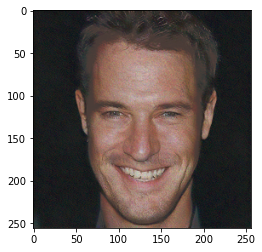

In [62]:
# parameters
half_patch_size = 2
patch_size = 2*half_patch_size+1
half_win_size = 5
win_size = 2*half_win_size+1

sigma = torch.tensor(10./255. * patch_size)

d = patch_size**2 # patch dim (no colors)
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=patch_size, dilation=1, padding=half_patch_size, stride=1)(img_tsr.view(3,1,img_tsr.size(2), img_tsr.size(3))) # 3 x d x N (with batch)

# computes mean
patch_mean = torch.mean(patch, 2, keepdim=True)
patch_centered = (patch - patch_mean)

# defines random linear projections
S = torch.randn(1,d,d)
S = S / torch.sqrt(torch.sum(S**2,1, keepdim=True)) # normalisation des vecteurs verticaux

if True : # ortho-normal basis (algorithme Gram-Schmidt)
    for i in range(1,d) :
        s = S[0,i,:]

        for j in range(i):
            v = S[0,j,:]
            proj = torch.dot(s, v) / torch.dot(v, v)
            s = s - proj * v
        
        S[0,i,:] = s / torch.sqrt(torch.sum(s**2,0, keepdim=True))



# filtering function
identity =  lambda val, thres : val
hard_thres = lambda val, thres : val * (abs(val) > thres)  # val if (val > thres) else torch.tensor(0.)
soft_thres = lambda val, thres : torch.sign(val) * torch.max(abs(val) - thres, torch.tensor(0.)) 

thres_fun = hard_thres # soft_thres

# perform filtering and reconstruction of patches
patch_random = torch.zeros_like(patch)
for c in range(3) :
    patch_random[c] = patch_mean[c] + ( S[0] @ thres_fun( S[0].transpose(1,0) @ patch_centered[c].squeeze(0), sigma ) ).unsqueeze(0)

# aggregation of patches (actual averaging of patch) 
# sum overlapping patch
synth_random = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(patch_random)
# normalisation by number of overlapping patch
synth_random /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch_random))

synth_random = synth_random.view(1,3,img_tsr.size(2),img_tsr.size(3)).detach()

plt.imshow(synth_random.squeeze(0).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

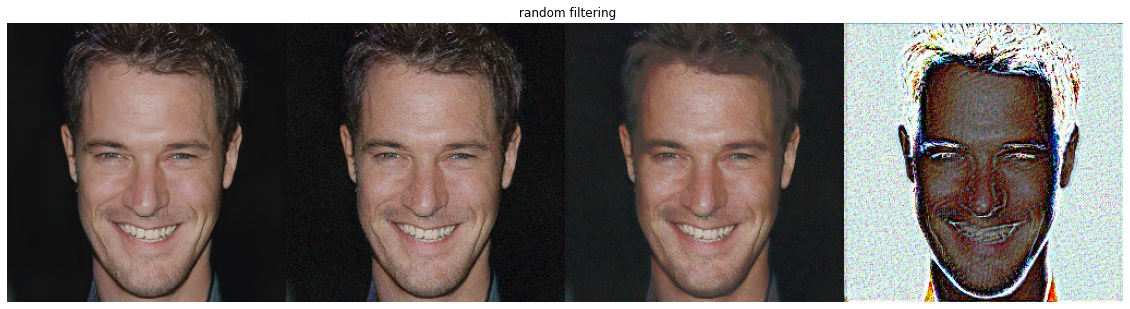

In [65]:
diff = (synth_random - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_random = torch.cat((img0_tsr,img_tsr,synth_random,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_random.squeeze(0).permute(1,2,0))
plt.title(" random filtering")
plt.axis("off")

Text(0.5, 1.0, 'noisy / NL means / NL PCA (batch color) / NL random ')

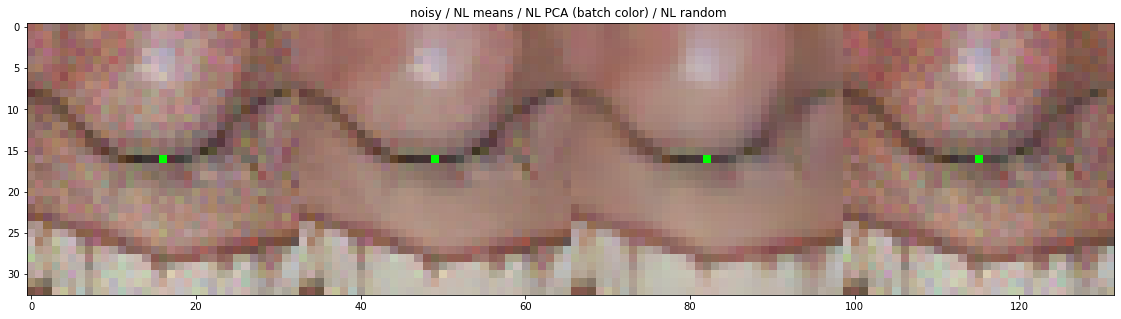

In [64]:
patch_random = synth_random[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_random[:,16,16] = torch.tensor([0,1,0])
patch_random = patch_random.permute(1,2,0) 
plt.figure(figsize=(20,5))
plt.imshow(torch.cat((patch_ori,patch_NLM,patch_NLPCA2,patch_random), 1))
plt.title("noisy / NL means / NL PCA (batch color) / NL random ")

## Auto-Encoder patch processing

tensor(0.1368)
tensor(0.3093)


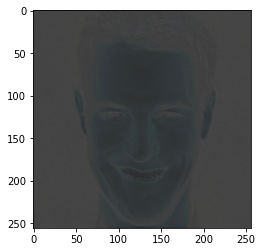

In [66]:
# parameters
half_patch_size = 1
patch_size = 2*half_patch_size+1
half_win_size = 5
win_size = 2*half_win_size+1

sigma = torch.tensor(5./255. * patch_size)

d = patch_size**2 # patch dim (no colors)
N = img_tsr.size(2) * img_tsr.size(3) # number of patch (= Number of pixels with appropriate padding)

# overlapping patch decomposition (sliding window)
patch = torch.nn.Unfold(kernel_size=patch_size, dilation=1, padding=half_patch_size, stride=1)(img_tsr.view(3,1,img_tsr.size(2), img_tsr.size(3))) # 3 x d x N (with batch)
# factoring 
patch = patch.permute(0,2,1).reshape(-1,d) # 3N x d

# computes mean
patch_mean = torch.mean(patch, 0, keepdim=True)
patch_centered = (patch - patch_mean)

# defines random linear transforms
Encoder = torch.nn.Linear(d,d, bias=False)
Decoder = torch.nn.Linear(d,d, bias=False)

# random embedding
patch_AE = Encoder(patch_centered)

# filtering function
identity =  lambda val, thres : val
hard_thres = lambda val, thres : val * (abs(val) > thres)  # val if (val > thres) else torch.tensor(0.)
soft_thres = lambda val, thres : torch.sign(val) * torch.max(abs(val) - thres, torch.tensor(0.)) 
thres_fun = hard_thres # soft_thres

patch_AE = thres_fun(patch_AE, 0.1)

# random decoding
patch_AE = patch_mean + Decoder(patch_AE)

# refactoring : 3N x d -> 3 x d x N
patch_AE = patch_AE.reshape(3,N,d).permute(0,2,1)

# aggregation of patches (actual averaging of patch) 
# sum overlapping patch
synth_AE = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(patch_AE)
# normalisation by number of overlapping patch
synth_AE /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch_AE))

#synth_AE = (0.5+torch.nn.Tanh()(synth_AE) * 10)
synth_AE = synth_AE.view(1,3,img_tsr.size(2),img_tsr.size(3)).detach()

plt.imshow(synth_AE.squeeze(0).permute(1,2,0))

print(synth_AE.min())
print(synth_AE.max())

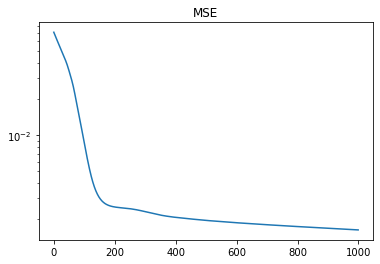

In [67]:
# training the auto-encoder

thres = .1 # arbitrary threshold

optim_Encoder = torch.optim.Adam(Encoder.parameters(), lr=0.001)
optim_Decoder = torch.optim.Adam(Decoder.parameters(), lr=0.001)

Loss = []
for it in range(1000) :
    Encoder.zero_grad()
    Decoder.zero_grad()

    patch_AE = Encoder(patch_centered)
    patch_AE = thres_fun(patch_AE, thres)
    patch_AE = patch_mean + Decoder(patch_AE)

    loss = torch.mean( (patch_AE - patch)**2 )
    Loss.append(loss.item())

    loss.backward()
    optim_Encoder.step()
    optim_Decoder.step()

plt.title("MSE")
plt.semilogy(Loss)

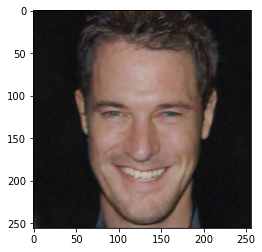

In [68]:
# pass
patch_AE = Encoder(patch_centered)
patch_AE = thres_fun(patch_AE, thres)
patch_AE = patch_mean + Decoder(patch_AE)

# refactoring : 3N x d -> 3 x d x N
patch_AE = patch_AE.reshape(3,N,d).permute(0,2,1)

if True : # aggregation of patches (actual averaging of patch) 
    # sum overlapping patch
    synth_AE = torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(patch_AE)
    # normalisation by number of overlapping patch
    synth_AE /= torch.nn.Fold((img_tsr.size(2),img_tsr.size(3)), patch_size, dilation=1, padding=half_patch_size, stride=1)(torch.ones_like(patch_AE))
else : # extract the central pixel of the patch
    n = (patch_size**2)//2
    synth_AE = patch_AE[:,n:n+1,:]

synth_AE = synth_AE.view(1,3,img_tsr.size(2),img_tsr.size(3)).detach()

plt.imshow(synth_AE.squeeze(0).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 255.5, -0.5)

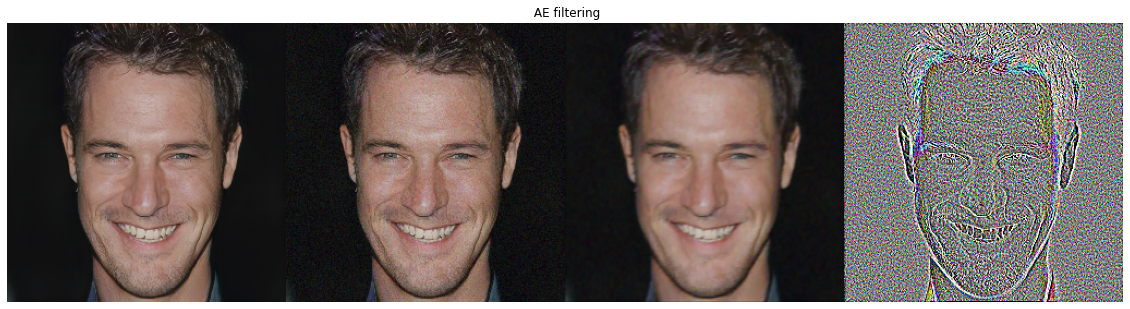

In [69]:
diff = (synth_AE - img_tsr) # in [-1,1]
diff = torch.clamp(10*diff,-1,1) + 0.5 # in [0,1]
res_AE = torch.cat((img0_tsr,img_tsr,synth_AE,diff),axis=3)

plt.figure(figsize=(20,20))
plt.imshow(res_AE.squeeze(0).permute(1,2,0))
plt.title(" AE filtering")
plt.axis("off")

Text(0.5, 1.0, 'noisy / NL means / NL PCA (batch color) / AE ')

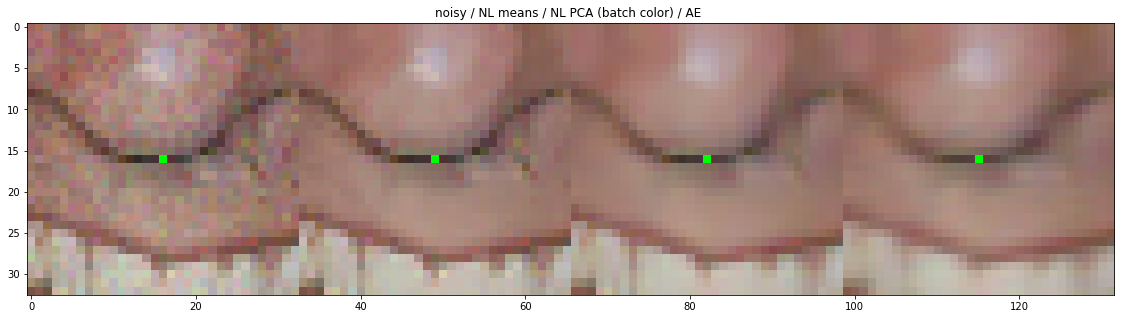

In [70]:
patch_AE = synth_AE[:,:,interest_point[0]-16:interest_point[0]+17, interest_point[1]-16:interest_point[1]+17].squeeze(0)
patch_AE[:,16,16] = torch.tensor([0,1,0])
patch_AE = patch_AE.permute(1,2,0) 
plt.figure(figsize=(20,5))
plt.imshow(torch.cat((patch_ori,patch_NLM,patch_NLPCA2,patch_AE), 1))
plt.title("noisy / NL means / NL PCA (batch color) / AE ")